1. Import Dependencies

In [3]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import mediapipe as mp

In [4]:
mp_holistic = mp.solutions.holistic  # it is basically for detection (models)
mp_drawing = mp.solutions.drawing_utils # it is basically for drawing that detection

In [6]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)

    return image,results

In [7]:
def draw_landmarks(image,results):
    #mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_CONTOURS)
   # mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS)

In [8]:
def draw_styled_landmarks(image,results):
    '''mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_CONTOURS
                              ,mp_drawing.DrawingSpec(color=(80,110,10),thickness=1,circle_radius=1)
                              ,mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1))
    
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS
                              ,mp_drawing.DrawingSpec(color=(80,22,10),thickness=2,circle_radius=4)
                              ,mp_drawing.DrawingSpec(color=(80,44,121),thickness=2,circle_radius=2))'''
    
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS
                              ,mp_drawing.DrawingSpec(color=(121,22,76),thickness=2,circle_radius=4)
                              ,mp_drawing.DrawingSpec(color=(121,44,250),thickness=2,circle_radius=2))
    
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS
                              ,mp_drawing.DrawingSpec(color=(245,117,66),thickness=2,circle_radius=4)
                              ,mp_drawing.DrawingSpec(color=(245,66,230),thickness=2,circle_radius=2))

2. KeyPoints using MP Holistic

In [18]:
capt = cv2.VideoCapture(0)

# SET MEDIAPIPE MODEL
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistics:

    while True:

        ret,frame = capt.read()

        # MAKE DETECTIONS

        image, results = mediapipe_detection(frame,holistics)

        draw_styled_landmarks(image,results)

        cv2.imshow('capture',image)

        if cv2.waitKey(10) & 0xFF == ord('a'):
            break

    capt.release()
    cv2.destroyAllWindows()


In [9]:
len(results.right_hand_landmarks.landmark)

NameError: name 'results' is not defined

In [20]:
image

array([[[200, 208, 201],
        [186, 194, 187],
        [182, 191, 183],
        ...,
        [225, 227, 200],
        [227, 227, 200],
        [227, 227, 200]],

       [[200, 212, 205],
        [185, 195, 189],
        [179, 188, 181],
        ...,
        [225, 227, 201],
        [226, 226, 201],
        [226, 226, 201]],

       [[196, 214, 209],
        [172, 186, 181],
        [181, 191, 185],
        ...,
        [227, 229, 208],
        [228, 229, 209],
        [228, 229, 209]],

       ...,

       [[159, 135, 122],
        [165, 142, 129],
        [149, 127, 114],
        ...,
        [ 15,  12,   4],
        [ 15,  12,   4],
        [ 16,  13,   5]],

       [[152, 133, 113],
        [159, 141, 122],
        [150, 132, 114],
        ...,
        [ 14,  11,   2],
        [ 15,  12,   2],
        [ 16,  14,   4]],

       [[147, 132, 108],
        [154, 139, 116],
        [146, 130, 109],
        ...,
        [ 12,  10,   0],
        [ 14,  12,   0],
        [ 15,  13,   2]]

In [21]:
draw_landmarks(image,results)

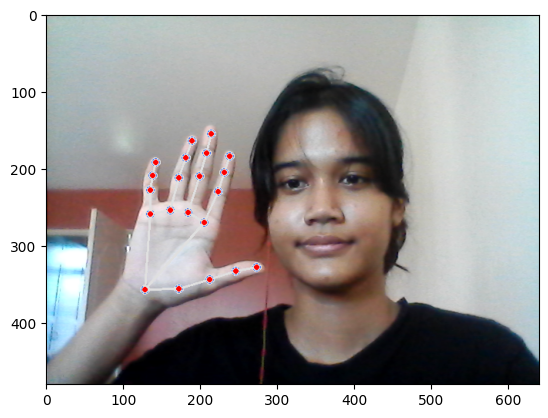

In [22]:
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

3. EXTRACT KEYPOINT VALUES

In [23]:
results.pose_landmarks

landmark {
  x: 0.5627143979072571
  y: 0.5240502953529358
  z: -1.5418548583984375
  visibility: 0.9996359944343567
}
landmark {
  x: 0.6005224585533142
  y: 0.45152467489242554
  z: -1.4258489608764648
  visibility: 0.9994316101074219
}
landmark {
  x: 0.6260110139846802
  y: 0.45326676964759827
  z: -1.4261698722839355
  visibility: 0.9991603493690491
}
landmark {
  x: 0.6455196142196655
  y: 0.4567912220954895
  z: -1.4265516996383667
  visibility: 0.999241828918457
}
landmark {
  x: 0.5274828672409058
  y: 0.4539078176021576
  z: -1.4022490978240967
  visibility: 0.9995614290237427
}
landmark {
  x: 0.5041850805282593
  y: 0.4566400945186615
  z: -1.4018076658248901
  visibility: 0.9995574951171875
}
landmark {
  x: 0.4807867109775543
  y: 0.4618397355079651
  z: -1.402404546737671
  visibility: 0.9997220635414124
}
landmark {
  x: 0.6844812035560608
  y: 0.5073724389076233
  z: -0.7331302762031555
  visibility: 0.9990525841712952
}
landmark {
  x: 0.457721471786499
  y: 0.5248382

In [61]:
# pose=[]
# for res in results.pose_landmarks.landmark:
#     test = np.array([res.x,res.y,res.z,res.visibility])
#     pose.append(test)

In [24]:
#print(len(results.pose_landmarks.landmark))
#print(len(results.face_landmarks.landmark))
print(len(results.right_hand_landmarks.landmark))
# print(len(results.left_hand_landmarks.landmark))

21


In [82]:
def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3) 
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose,face,lh,rh])

In [83]:
extract_keypoints(results).shape

(1662,)

In [84]:
33*4+468*3+21*3+21*3

1662

4. Setup Folders For Collections

In [85]:
DATA_PATH = os.path.join('D:\\MP_Data')
actions = np.array(['hello','iloveyou','good','okay'])
no_sequence = 30 # 30 examples for each action(label) total 90
sequence_length = 30 # each of the training data will be of 30 frames

In [ ]:
# MP_Data ----- > Hello ----> 0,1,2,.....29
        # ----- > thanks ----> 0,1,2,....29
#         ----- > iloveyou ----> 0,1,2,....29

In [86]:
for action in actions:
    for sequence in range(no_sequence):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
            pass

5. Collect Keypoint Sequences

In [33]:
capt = cv2.VideoCapture(0)

# SET MEDIAPIPE MODEL
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistics:

    for action in actions:
        for sequence in range(no_sequence):
            for frame_num in range(sequence_length):


                ret,frame = capt.read()

                # MAKE DETECTIONS

                image, results = mediapipe_detection(frame,holistics)

                draw_styled_landmarks(image,results)

                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),4,cv2.LINE_AA)

                    cv2.putText(image, 'Collecting frames for {} video number {}'.format(actions,sequence), (15,12)
                                , cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),4,cv2.LINE_AA)
                    
                    cv2.waitKey(2000)

                else:
                    cv2.putText(image, 'Collecting frames for {} video number {}'.format(action,sequence), (15,12)
                                , cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),4,cv2.LINE_AA)
                    
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH,action,str(sequence),str(frame_num))
                np.save(npy_path,keypoints)


                cv2.imshow('capture',image)

                if cv2.waitKey(10) & 0xFF == 27:
                    break

    capt.release()
    cv2.destroyAllWindows()


In [34]:
capt.release()
cv2.destroyAllWindows()

6. Preprocess Data and Create Labels and Features

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [19]:
label_map = {label:num for num,label in enumerate(actions)}

In [20]:
label_map

{'hello': 0, 'iloveyou': 1, 'good': 2, 'okay': 3}

In [21]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequence):
        window=[]
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH,action,str(sequence), '{}.npy'.format(frame_num)))
            window.append(res)

        sequences.append(window)
        labels.append(label_map[action])


In [22]:
np.array(sequences).shape

(120, 30, 1662)

In [87]:
np.array(labels).shape

(120,)

In [24]:
X= np.array(sequences)
y = to_categorical(labels,4).astype(int)

In [25]:
y


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1,

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05,random_state=42)

7. BUILD AND TRAIN LSTM NEURAL NETWORK

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [113]:
log_dir = os.path.join('D:\\Logs')
tb_callbacks = TensorBoard(log_dir=log_dir)

In [114]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(actions.shape[0], activation='softmax'))

In [115]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [116]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596708 (2.28 MB)
Trainable params: 59670

In [157]:
model.fit(X_train, y_train, epochs=500, verbose =2)

Epoch 1/500
4/4 - 1s - loss: 0.7966 - categorical_accuracy: 0.6140 - 814ms/epoch - 204ms/step
Epoch 2/500
4/4 - 1s - loss: 0.7501 - categorical_accuracy: 0.6754 - 934ms/epoch - 234ms/step
Epoch 3/500
4/4 - 1s - loss: 0.7519 - categorical_accuracy: 0.6667 - 589ms/epoch - 147ms/step
Epoch 4/500
4/4 - 1s - loss: 0.7291 - categorical_accuracy: 0.7018 - 521ms/epoch - 130ms/step
Epoch 5/500
4/4 - 1s - loss: 0.7554 - categorical_accuracy: 0.6140 - 573ms/epoch - 143ms/step
Epoch 6/500
4/4 - 1s - loss: 0.6941 - categorical_accuracy: 0.7105 - 583ms/epoch - 146ms/step
Epoch 7/500
4/4 - 1s - loss: 0.7897 - categorical_accuracy: 0.6579 - 779ms/epoch - 195ms/step
Epoch 8/500
4/4 - 1s - loss: 0.7220 - categorical_accuracy: 0.7456 - 555ms/epoch - 139ms/step
Epoch 9/500
4/4 - 1s - loss: 0.7585 - categorical_accuracy: 0.6667 - 544ms/epoch - 136ms/step
Epoch 10/500
4/4 - 1s - loss: 0.7913 - categorical_accuracy: 0.6228 - 710ms/epoch - 178ms/step
Epoch 11/500
4/4 - 1s - loss: 0.8506 - categorical_accuracy

In [111]:
#del model

8. Make Predictions

In [158]:
pred_prob = model.predict(X_test)

1/1 [==============================] - 0s 122ms/step


In [159]:
pred_prob

array([[6.0147403e-07, 9.4155717e-01, 2.5440633e-02, 3.3001654e-02],
       [1.9734532e-07, 9.6865284e-01, 3.2339459e-03, 2.8112983e-02],
       [9.5661163e-01, 4.2728629e-02, 7.3615039e-09, 6.5966236e-04],
       [3.6233837e-07, 9.6258271e-01, 6.0435603e-03, 3.1373348e-02],
       [9.6491933e-01, 3.4762487e-02, 3.1267657e-09, 3.1825044e-04],
       [2.6708824e-06, 2.7505824e-02, 9.7019088e-01, 2.3006657e-03]],
      dtype=float32)

In [160]:
np.sum(pred_prob[0])

1.0

In [161]:
np.argmax(pred_prob[0]) # reyurn index number

1

In [162]:
actions[np.argmax(pred_prob[4])]

'hello'

In [163]:
actions[np.argmax(y_test[2])]

'hello'

9. Save weights

In [165]:
model.save("D:\\MP_DATA\\actions.h5")

In [166]:
model.load_weights("D:\\MP_DATA\\actions.h5")

10. Evaluation Using Confusion Metric and Accuracy

In [167]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [168]:
y_true = np.argmax(y_test,axis=1).tolist()
y_pred = np.argmax(pred_prob,axis=1).tolist()

In [169]:
multilabel_confusion_matrix(y_true,y_pred)

array([[[4, 0],
        [0, 2]],

       [[3, 0],
        [0, 3]],

       [[5, 0],
        [0, 1]]], dtype=int64)

In [170]:
accuracy_score(y_true,y_pred)

1.0

11.     Test In Real Time

In [171]:
from scipy import stats

In [172]:
def prob_viz(res, actions, input_frame):
    output_frame = input_frame.copy()
    
    for num, (action, prob) in enumerate(zip(actions, res)):
        # Display the action name and its probability
        text = f"{action}: {prob:.2f}"
        cv2.putText(output_frame, text, (40, 60 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return output_frame

In [173]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize the VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('D:\\output3.avi', fourcc, 6.0, (640, 480))

# Rest of your code
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
            # 3. Viz logic
            if np.unique(predictions[-10:])[0] == np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1: 
                sentence = sentence[-1:]

            # Viz probabilities
            image = prob_viz(res, actions, image)
            
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Write the frame to the video
        out.write(image)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the VideoWriter and capture
out.release()
cap.release()
cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [91]:
np.max(res)

0.59792614

In [92]:
cap.release()
cv2.destroyAllWindows()